In [1]:
import nibabel as nib
import multiprocessing
import os
import numpy as np
import os.path as op
import seaborn as sns
import matplotlib
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import svm
from sklearn import preprocessing
from sklearn.cross_decomposition import PLSRegression
import pickle
from ipyparallel import Client
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score, permutation_test_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import LinearSVC
%matplotlib inline

/home/iballard/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
rc = Client()

In [3]:
#preliminary housekeeping
home_dir = '/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)

In [4]:
exp = 'sim_4mm-betas'
# masks = ['entorhinal','peri_sim','para_sim','hipp','yeo17_ifs',
#          'lOFC_fill_sim','mOFC_fill_sim','sim_4mm_striatum_mask']
masks = ['hipp','sim_4mm_striatum_limbic_mask','sim_4mm_striatum_frontal_mask']
smooth = 'smoothed'

In [5]:
def get_condition(i):
    if i < 11:
        cond = 'b_plus'
        trial = i
    elif i < 21:
        cond = 'c_plus'
        trial = i - 10
    elif i < 31:
        cond = 'c_minus'
        trial = i - 20
    elif i < 41:
        cond = 'b_minus'
        trial = i - 30
    return cond,trial

In [9]:
#set ROIs of interest and load from hard disk
def load_whitened_betas(rois):
    smooth = 'smoothed'
    betas = []
    for sub in subs:
        for m in set(rois):
            out_f = op.join(home_dir,'betas', 'whitened','_'.join(['sim_4mm-betas',sub,smooth,m]) + '.csv')
            betas.append(pd.read_csv(out_f))
    betas = pd.concat(betas)
    betas = betas.set_index(['sub', 'mask','run'])

    return betas


In [11]:
#set ROIs of interest and load from hard disk
def load_betas(rois):
    betas = []
    for sub in subs:
        for m in set(rois):
            f = op.join(home_dir,'betas','whitened', '_'.join([exp,sub,smooth,m]) + '.csv')
            f = pd.read_csv(f)
            betas.append(f)

    betas = pd.concat(betas)
    betas = betas.set_index(['sub', 'mask','run'])
    
    return betas

In [13]:
betas = load_whitened_betas(['hipp','sim_4mm_striatum_PE_mf_mask'])

In [19]:
X = betas.loc[('fd_104','hipp',1)]
set(X['trial'])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [28]:
def multi_connect(x_roi,y_roi,betas):
    scores_df = {'sub':[],'score_test':[],'score_train':[],'y_roi':[],'x_roi':[]}
    for sub in subs:
        scores_train = []
        scores_test = []

        #deal with unequal number of runs across subjects
        runs = list(set(betas.loc[(sub,x_roi)].index))
        if len(runs) == 3:
            train_runs = [['1','2'],['1','3'],['2','3']]
        elif len(runs) == 2:
            train_runs = [['1'],['2']]

        for train_set in train_runs:
            X_train = []
            Y_train = []
            for run in runs:
                #extract relevant data from betas df
                X = betas.loc[(sub,x_roi,run)]
                X = X.pivot(index = 'row',columns='voxel', values='value').values

                if x_roi == y_roi:
                    Y = np.copy(X)
                else:    
                    Y = betas.loc[(sub,y_roi,run)]
                    Y = Y.pivot(index = 'row',columns='voxel', values='value').values

                if str(run) in train_set:
                    X_train.append(np.copy(X))
                    Y_train.append(np.copy(Y))
                else:
                    X_test = np.copy(X)
                    Y_test = np.copy(Y)

            #format design matrices for input to sklearn
            X_train = np.array(X_train)
            Y_train = np.array(Y_train)        

            X_train = X_train.reshape(-1, X_train.shape[-1])
            Y_train = Y_train.reshape(-1, Y_train.shape[-1])

            #standardize
            X_train = preprocessing.scale(X_train)
            Y_train = preprocessing.scale(Y_train)
            X_test = preprocessing.scale(X_test)
            Y_test = preprocessing.scale(Y_test)

            #compute PLS
            pls = PLSRegression(n_components=2,max_iter = 2000)
            pls.fit(X_train,Y_train)

            score_train = pls.score(X_train,Y_train)
            scores_train.append(score_train)

            score_test = pls.score(X_test,Y_test)
            scores_test.append(score_test)

    #save to DF
    scores_df['sub'].append(sub)
    scores_df['x_roi'].append(x_roi)
    scores_df['y_roi'].append(y_roi)
    scores_df['score_test'].append(np.mean(scores_test))
    scores_df['score_train'].append(np.mean(scores_train))
    scores_df = pd.DataFrame(scores_df)
    return scores_df

In [29]:
def run_pls(in_tuple):
    x_roi, y_roi = in_tuple
    out_f = op.join(home_dir,'multi_connectivity', x_roi + '_to_' + y_roi + '_sim_white.pkl')

    if True:#not op.exists(out_f):
        betas = load_whitened_betas([x_roi,y_roi])
        scores = multi_connect(x_roi,y_roi,betas)

        # write to a file 
        output = open(out_f, 'wb')
        pickle.dump(scores, output)
        output.close()

In [30]:
# rois = ['hipp','peri_sim','para_sim',
#         'mOFC_fill_sim','yeo17_ifs',]
rois = masks
roi_pairs = []
for i in range(0,len(rois)):
    for j in range(0,len(rois)):
        if i <= j:
            roi_pairs.append((rois[i],rois[j]))
run_pls(roi_pairs[1])

In [100]:
dview = rc[0:8]
dview.block = True

dview.push(dict(home_dir=home_dir,
                exp = exp,
                subs = subs,
                smooth = smooth,
                load_betas = load_betas,
                load_whitened_betas = load_whitened_betas,
                multi_connect = multi_connect
                ))
dview.execute("import numpy as np")
dview.execute("import os.path as op")
dview.execute("import nibabel as nib")
dview.execute("import pandas as pd")
with dview.sync_imports():
    import os
    import numpy
    import scipy
    import scipy.stats
    import pickle
    import sklearn
    from sklearn import preprocessing
    from sklearn.cross_decomposition import PLSRegression
dview.map_sync(run_pls,roi_pairs)

importing os on engine(s)
importing numpy on engine(s)
importing scipy on engine(s)
importing scipy.stats on engine(s)
importing pickle on engine(s)
importing sklearn on engine(s)
importing preprocessing from sklearn on engine(s)
importing PLSRegression from sklearn.cross_decomposition on engine(s)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [101]:
df = []
for tup in roi_pairs:
    x_roi,y_roi = tup
    out_f = op.join(home_dir,'multi_connectivity', x_roi + '_to_' + y_roi + '_sim_white.pkl')
    
    if op.exists(out_f):

        pkl_file = open(out_f, 'rb')
        data = pickle.load(pkl_file)

        df.append(data)

        pkl_file.close()
df = pd.concat(df)

In [102]:
means = df.groupby(['x_roi','y_roi']).mean().unstack()['score_test']
df = df.set_index(['x_roi','y_roi'])


In [33]:
out_f = op.join(home_dir,'multi_connectivity', masks[0] + '_to_' + masks[1] + '_sim_white.pkl')
pkl_file = open(out_f, 'rb')
data = pickle.load(pkl_file)
# data
# scipy.stats.ttest_1samp(data['score_test'],0)

In [107]:
sig = {'x_roi':[],'y_roi':[],'sig':[]}
for x in rois:
    for y in rois:
        try:
            vals = df.loc[(x,y),'score_test'].values
        except:
            vals = df.loc[(y,x),'score_test'].values
        is_sig = int(scipy.stats.ttest_1samp(vals,0)[1] > .005)
        sig['x_roi'].append(x)
        sig['y_roi'].append(y)
        sig['x_roi'].append(y)
        sig['y_roi'].append(x)
        sig['sig'].append(is_sig)
        sig['sig'].append(is_sig)
sig = pd.DataFrame(sig)
sig = sig.groupby(['x_roi','y_roi']).mean().unstack()['sig']
mask = sig.values
mask[np.triu_indices_from(mask,1)] = True

In [108]:
def make_symmetric(df,rois):
    for n1,x in enumerate(rois):
        for n2,y in enumerate(rois):
            if n1 < n2:
                entry1 = df[x][y]
                entry2 = df[y][x]
                if np.isnan(entry1):
                    df[x][y] = entry2
                if np.isnan(entry2):
                    df[y][x] = entry1
    return df

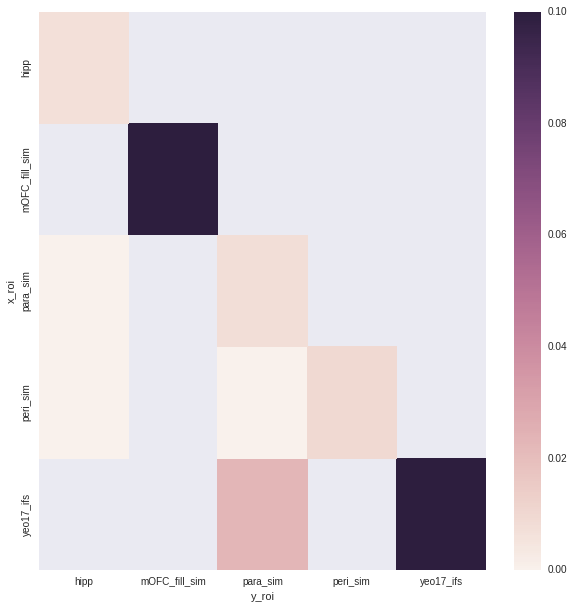

In [109]:

means = make_symmetric(means,rois)
sns.set(rc={"figure.figsize": (10, 10)})
sns.heatmap(means,mask = mask, vmin = 0, vmax = .1)

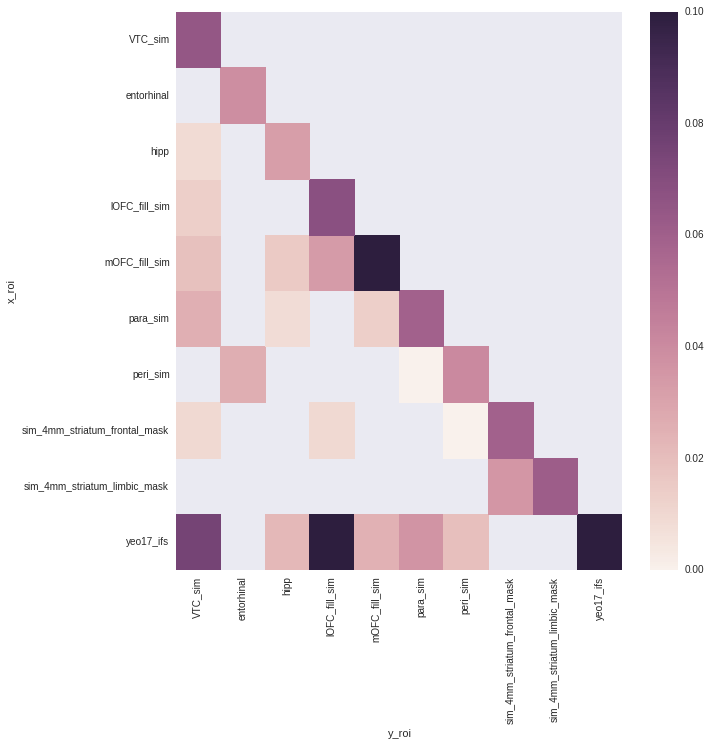

In [54]:

means = make_symmetric(means,rois)
sns.set(rc={"figure.figsize": (10, 10)})
sns.heatmap(means,mask = mask, vmin = 0, vmax = .1)

# examine content of connectivity


In [65]:
# betas = load_betas(['para_sim','peri_sim','mOFC_fill_sim','lOFC_fill_sim',
#                     'VTC_sim','yeo17_ifs','hipp'])
betas = load_whitened_betas(['mOFC_fill_sim','yeo17_ifs','hipp'])

In [66]:
# def mvpa(roi,betas):
#     all_cnf = []
#     scores_df = {'sub':[],'score':[],'roi':[]}
#     for sub in subs:
        
#         ##get X data
#         runs = list(set(betas.loc[(sub,roi)].index))
#         X_data = []
#         for run in runs:
#             X = betas.loc[(sub,roi,run)]
#             X = X.pivot(index = 'row',columns='voxel', values='value').values
#             X_data.append(np.copy(X))
#         X_data = np.array(X_data)
#         X_data = X_data.reshape(-1, X_data.shape[-1])
#         X_data = preprocessing.scale(X_data)

#         #get y
#         sub_betas = betas.loc[(sub,roi)]
#         y = sub_betas[sub_betas['voxel'] == 0]['condition'].values
# #         ymap = {'b_plus':'+','c_plus':'+','b_minus':'-','c_minus':'-'}
#         ymap = {'b_plus':0,'c_plus':1,'b_minus':2,'c_minus':3}
#         y = np.array([ymap[x] for x in y])
        
#         #compute cross-val
#         runs = sub_betas[sub_betas['voxel'] == 0].index.values
#         cv = LeaveOneLabelOut(runs)

#         #compute cross-val score
#         linearSVM = svm.SVC(kernel='linear')
#         logistic = LogisticRegression(C=1)
# #         clf = Pipeline([('anova',anova),('classification',logistic)])
#         pca = decomposition.PCA(n_components = 20)
#         clf = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
        
#         res = cross_val_score(logistic, X_data, y, cv=cv, scoring = 'accuracy')
#         score = np.mean(res)
        
#         #compute confusion matrix
#         cnf = []
#         for train_index, test_index in cv:
#             X_train, X_test = X_data[train_index], X_data[test_index]
#             y_train, y_test = y[train_index], y[test_index]

#             y_pred = clf.fit(X_train, y_train).predict(X_test)
#             cnf_matrix = confusion_matrix(y_test, y_pred)
#             cnf.append(cnf_matrix)
#         cnf = np.array(cnf)
#         all_cnf.append(cnf.mean(0))

#         #compile results
#         scores_df['roi'].append(roi)
#         scores_df['sub'].append(sub)
#         scores_df['score'].append(score)
#         print sub,score
#     return pd.DataFrame(scores_df), all_cnf



In [54]:
def mvpa(roi,betas):
    all_cnf = []
    scores_df = {'sub':[],'score':[],'roi':[]}
    for sub in subs:
        
        runs_score = []
        runs_cnf = []
        runs = list(set(betas.loc[(sub,roi)].index))
        for run in runs:
        
            ##get X data
            sub_betas = betas.loc[(sub,roi,run)]
            X_data = sub_betas.pivot(index = 'row',columns='voxel', values='value').values
            X_data = preprocessing.scale(X_data)

            #get y
            y = sub_betas[sub_betas['voxel'] == 0]['condition'].values
            ymap = {'b_plus':0,'c_plus':1,'b_minus':2,'c_minus':3}
            y = np.array([ymap[x] for x in y])

            #cross val
            skf = StratifiedKFold(y,n_folds=3)

            #set up classifier
            logistic = LogisticRegression(C=1)
            pca = decomposition.PCA(n_components = 20)
            clf = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

            #compute cross-val score
            res = cross_val_score(clf, X_data, y, cv=skf, scoring = 'accuracy')
            score = np.mean(res)
            runs_score.append(score)
            
            #compute confusion matrix
            cnf = []
            for train_index, test_index in skf:
                X_train, X_test = X_data[train_index], X_data[test_index]
                y_train, y_test = y[train_index], y[test_index]

                y_pred = clf.fit(X_train, y_train).predict(X_test)
                cnf_matrix = confusion_matrix(y_test, y_pred)
                cnf.append(cnf_matrix)
            runs_cnf.append(np.array(cnf).mean(0))
            
        #compile results
        all_cnf.append(np.array(runs_cnf).mean(0))
        scores_df['roi'].append(roi)
        scores_df['sub'].append(sub)
        scores_df['score'].append(np.mean(runs_score))
        print sub,score
    return pd.DataFrame(scores_df), all_cnf

In [55]:
#project a onto be
def vector_project(a,b):
    return (np.dot(a,b)/np.dot(b,b)) * b
    

In [56]:
roi = 'hipp'
scores_fd, all_cnf = mvpa(roi,betas)


fd_104 1.0
fd_105 1.0
fd_107 1.0
fd_108 1.0
fd_109 1.0



KeyboardInterrupt


In [51]:
print scores_fd.mean()
print scipy.stats.ttest_1samp(scores_fd['score'],.25)
# plt.hist(scores_fd['score'] - .25)

score    0.993924
dtype: float64
Ttest_1sampResult(statistic=446.68122835676689, pvalue=1.3119607340710525e-60)


In [52]:
def make_fig(rois,all_cnf):
    sns.set(rc={"figure.figsize": (8, 8)})
    cnf = np.mean(np.array(all_cnf),0)/10.0
    for i in range(cnf.shape[0]):
        for j in range(cnf.shape[0]):
            if i < j:
                avg = np.mean([cnf[i,j],cnf[j,i]])
                cnf[i,j] = avg
                cnf[j,i] = avg
    ymap = {'b_plus':0,'c_plus':1,'b_minus':2,'c_minus':3}

    mask = np.zeros_like(cnf, dtype=np.bool)
    mask[np.triu_indices_from(mask,1)] = True

    cnf = pd.DataFrame(cnf, index = ['AB+','C+','B-','AC-'], 
                       columns = ['AB+','C+','B-','AC-'])
    sns.heatmap(cnf,mask= mask)
    plt.title('_to_'.join(rois))
    plt.savefig('/home/iballard/fd/connectivity/mvpa_' + '_'.join(rois) + '.png')

/home/iballard/.local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


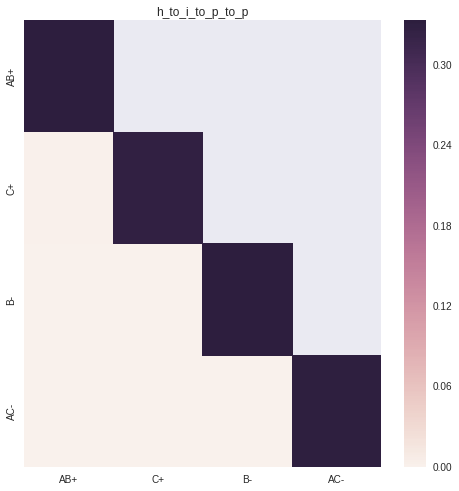

In [53]:
make_fig(roi,all_cnf)

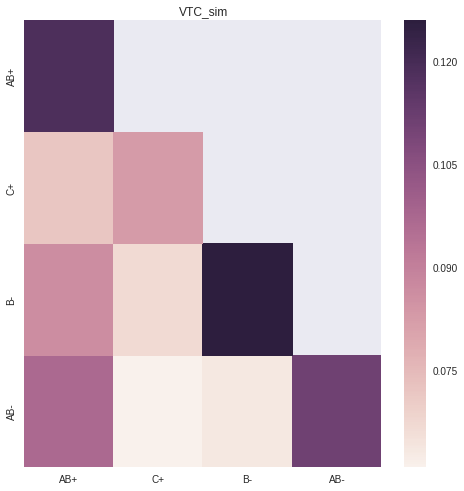

In [636]:
make_fig(roi,all_cnf)

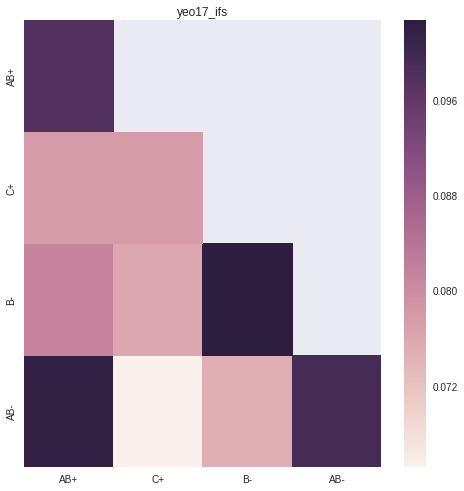

In [638]:
make_fig(roi,all_cnf)

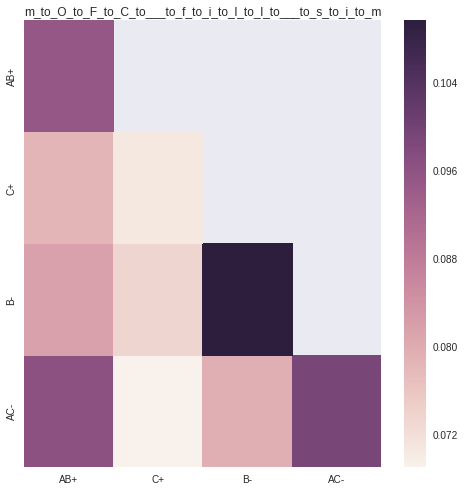

In [660]:
make_fig(roi,all_cnf)

In [661]:
# def connect_mvpa(x_roi, y_roi, betas):
#     pls_score = 0
#     all_cnf = []
#     scores_df = {'sub':[],'score':[],'roi':[],'pls_score':[]}
#     for sub in subs:
        
#         ##get X,Y data
#         runs = list(set(betas.loc[(sub,roi)].index))
#         X_data = []
#         Y_data = []
#         for run in runs:
#             X = betas.loc[(sub,x_roi,run)]
#             X = X.pivot(index = 'row',columns='voxel', values='value').values
#             X_data.append(np.copy(X))
            
#             Y = betas.loc[(sub,y_roi,run)]
#             Y = Y.pivot(index = 'row',columns='voxel', values='value').values
#             Y_data.append(np.copy(Y))
        
#         #format data nicely
#         X_data = np.array(X_data)
#         X_data = X_data.reshape(-1, X_data.shape[-1])
#         X_data = preprocessing.scale(X_data)
        
#         Y_data = np.array(Y_data)
#         Y_data = Y_data.reshape(-1, Y_data.shape[-1])
#         Y_data = preprocessing.scale(Y_data)
        
#         #compute cross-val
#         sub_betas = betas.loc[(sub,roi)]
#         runs = sub_betas[sub_betas['voxel'] == 0].index.values
#         cv = LeaveOneLabelOut(runs)

#         #compute PLS dimensionality reduction
#         pls = PLSRegression(n_components=2,max_iter = 2000)
# #         X_data, Y_data = pls.fit_transform(X_data,Y_data)
# #         pls.fit(X_data,Y_data)
# #         Y_pred = pls.predict(X_data)

#         predictions = []
#         pls_score = []
#         for train_index, test_index in cv:
#             X_train, X_test = X_data[train_index], X_data[test_index]
#             y_train, y_test = Y_data[train_index], Y_data[test_index]
            
#             #deal with scaling
#             X_train = preprocessing.scale(X_train)
#             y_train = preprocessing.scale(y_train)
#             X_test = preprocessing.scale(X_test)
#             y_test = preprocessing.scale(y_test)
                
#             #fit and assess
#             pls.fit(X_train,y_train)
#             pls_score.append(pls.score(X_test, y_test))

#             #track predictions
#             y_pred = pls.predict(X_test)
#             predictions.append(y_pred)
            
#         pls_score = np.mean(pls_score)
#         Y_pred = np.array(predictions)
#         Y_pred = Y_pred.reshape(-1, Y_pred.shape[-1])

#         #project Y_data onto Y_pred
#         Y_projection = []
#         for row1,row2 in zip(Y_data,Y_pred):
#             new_row = vector_project(row1,row2)
#             Y_projection.append(new_row)
#         Y_data = np.array(Y_projection)
#         Y_data = preprocessing.scale(Y_data)
        
#         #get y
#         y = sub_betas[sub_betas['voxel'] == 0]['condition'].values
#         ymap = {'b_plus':0,'c_plus':1,'b_minus':2,'c_minus':3}
#         y = np.array([ymap[x] for x in y])
        
#         #compute cross-val score
#         logistic = LogisticRegression(C=1)
# #         clf = svm.SVC(kernel='linear')
#         pca = decomposition.PCA(n_components = 4)
#         clf = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
        
#         res = cross_val_score(clf, Y_data, y, cv=cv, scoring = 'accuracy')
#         score = np.mean(res)
        
#         #compute confusion matrix
#         cnf = []
#         for train_index, test_index in cv:
#             X_train, X_test = Y_data[train_index], Y_data[test_index]
#             y_train, y_test = y[train_index], y[test_index]
            
# #             #deal with scaling
# #             X_train = preprocessing.scale(X_train)
# #             y_train = preprocessing.scale(y_train)
# #             X_test = preprocessing.scale(X_test)
# #             y_test = preprocessing.scale(y_test)
            
#             y_pred = clf.fit(X_train, y_train).predict(X_test)
#             cnf_matrix = confusion_matrix(y_test, y_pred)
#             cnf.append(cnf_matrix)
#         cnf = np.array(cnf)
#         all_cnf.append(cnf.mean(0))

#         #compile results
#         scores_df['roi'].append(roi)
#         scores_df['sub'].append(sub)
#         scores_df['score'].append(score)
#         scores_df['pls_score'].append(pls_score)
#         print sub, score, pls_score
#     return pd.DataFrame(scores_df), all_cnf



In [67]:
def connect_mvpa(x_roi, y_roi, betas):
    pls_score = 0
    all_cnf = []
    scores_df = {'sub':[],'score':[],'roi':[],'pls_score':[]}
    for sub in subs:
        
        ##get X,Y data
        runs = list(set(betas.loc[(sub,roi)].index))
        X_data = []
        Y_data = []
        for run in runs:
            X = betas.loc[(sub,x_roi,run)]
            X = X.pivot(index = 'row',columns='voxel', values='value').values
            X_data.append(np.copy(X))
            
            Y = betas.loc[(sub,y_roi,run)]
            Y = Y.pivot(index = 'row',columns='voxel', values='value').values
            Y_data.append(np.copy(Y))
        
        #format data nicely
        X_data = np.array(X_data)
        X_data = X_data.reshape(-1, X_data.shape[-1])
        X_data = preprocessing.scale(X_data)
        
        Y_data = np.array(Y_data)
        Y_data = Y_data.reshape(-1, Y_data.shape[-1])
        Y_data = preprocessing.scale(Y_data)
        
        #compute cross-val
        sub_betas = betas.loc[(sub,roi)]
        runs = sub_betas[sub_betas['voxel'] == 0].index.values
        cv = LeaveOneLabelOut(runs)

        #compute PLS dimensionality reduction
        pls = PLSRegression(n_components=n_pls,max_iter = 2000)
#         X_data, Y_data = pls.fit_transform(X_data,Y_data)
#         pls.fit(X_data,Y_data)
#         Y_pred = pls.predict(X_data)

        predictions = []
        pls_score = []
        for train_index, test_index in cv:
            X_train, X_test = X_data[train_index], X_data[test_index]
            y_train, y_test = Y_data[train_index], Y_data[test_index]
            
            #deal with scaling
            X_train = preprocessing.scale(X_train)
            y_train = preprocessing.scale(y_train)
            X_test = preprocessing.scale(X_test)
            y_test = preprocessing.scale(y_test)
                
            #fit and assess
            pls.fit(X_train,y_train)
            pls_score.append(pls.score(X_test, y_test))

            #track predictions
            y_pred = pls.predict(X_test)
            predictions.append(y_pred)
            
        pls_score = np.mean(pls_score)
        Y_pred = np.array(predictions)
        Y_pred = Y_pred.reshape(-1, Y_pred.shape[-1])

        #project Y_data onto Y_pred
#         Y_projection = []
#         for row1,row2 in zip(Y_data,Y_pred):
#             new_row = vector_project(row1,row2)
#             Y_projection.append(new_row)
#         Y_data = np.array(Y_projection)
#         Y_data = preprocessing.scale(Y_data)
        Y_projection = []
        for row1,row2 in zip(np.transpose(Y_data),np.transpose(Y_pred)):
            new_row = vector_project(row1,row2)
            Y_projection.append(new_row)
        Y_data = np.transpose(Y_projection)
#         Y_data = preprocessing.scale(Y_data)
        
        #now do classification
        runs_cnf = []
        runs_score = []
        for run in list(set(betas.loc[(sub,roi)].index)):
            #get X
            idx = [runs == run]
            X_data = Y_data[idx]

            #get y
            sub_betas = betas.loc[(sub,roi,run)]
            y = sub_betas[sub_betas['voxel'] == 0]['condition'].values
            ymap = {'b_plus':0,'c_plus':1,'b_minus':2,'c_minus':3}
            y = np.array([ymap[x] for x in y])
        
            #cross val
            skf = StratifiedKFold(y,n_folds=3)

            #set up classifier
            logistic = LogisticRegression(C=1)
            pca = decomposition.PCA(n_components = 20)
            clf = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

            #compute cross-val score
            res = cross_val_score(clf, X_data, y, cv=skf, scoring = 'accuracy')
            score = np.mean(res)
            runs_score.append(score)
            
            #compute confusion matrix
            cnf = []
            for train_index, test_index in skf:
                X_train, X_test = X_data[train_index], X_data[test_index]
                y_train, y_test = y[train_index], y[test_index]

                y_pred = clf.fit(X_train, y_train).predict(X_test)
                cnf_matrix = confusion_matrix(y_test, y_pred)
                cnf.append(cnf_matrix)
            runs_cnf.append(np.array(cnf).mean(0))
            
        #compile results
        all_cnf.append(np.array(runs_cnf).mean(0))
        scores_df['roi'].append(x_roi)
        scores_df['sub'].append(sub)
        scores_df['score'].append(np.mean(runs_score))
        scores_df['pls_score'].append(pls_score)
        print sub,np.mean(runs_score), pls_score
    return pd.DataFrame(scores_df), all_cnf



In [68]:
n_pls = 3
x_roi = 'mOFC_fill_sim'
y_roi = 'yeo17_ifs'
scores_fd, all_cnf = connect_mvpa(x_roi,y_roi,betas)

fd_104 0.199074074074 0.0247169464505
fd_105 0.203703703704 0.00976394308748
fd_107 0.243055555556 -0.00670186369083
fd_108 0.284722222222 -0.0142202507689
fd_109 0.231481481481 -0.0459671898775
fd_110 0.24537037037 -0.0102066800959
fd_112 0.219907407407 -0.011945932807
fd_113 0.261574074074 0.0170866920857
fd_114 0.331018518519 -0.0300372825654
fd_115 0.25462962963 0.0129925228032
fd_117 0.310185185185 0.0575846552211
fd_118 0.331018518519 -0.0138829067295
fd_119 0.231481481481 -0.00726078124622
fd_122 0.268518518519 0.208125948295
fd_123 0.25462962963 0.0216699201586
fd_124 0.19212962963 0.0825474522699
fd_126 0.277777777778 0.00600495201712
fd_127 0.329861111111 -0.0212808708042
fd_128 0.268518518519 0.000274925797999
fd_129 0.25 0.122536971451
fd_130 0.293981481481 0.0166455174702
fd_132 0.222222222222 0.00219701458981
fd_133 0.256944444444 0.10791076455
fd_135 0.240740740741 0.167058438873
fd_136 0.215277777778 0.118521429336
fd_137 0.263888888889 -0.018596929604
fd_138 0.28472222

In [69]:
print scores_fd.mean()
print scipy.stats.ttest_1samp(scores_fd['score'],.25)
print scipy.stats.ttest_1samp(scores_fd['pls_score'],0)

pls_score    0.032850
score        0.257921
dtype: float64
Ttest_1sampResult(statistic=1.0765414587398525, pvalue=0.289992133397868)
Ttest_1sampResult(statistic=2.9185390696884741, pvalue=0.0064941591398162161)


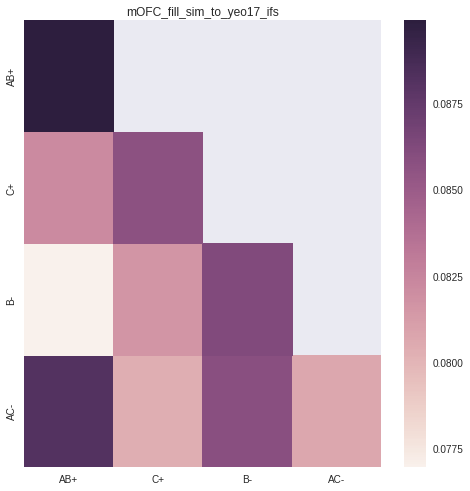

In [70]:
make_fig([x_roi,y_roi],all_cnf)

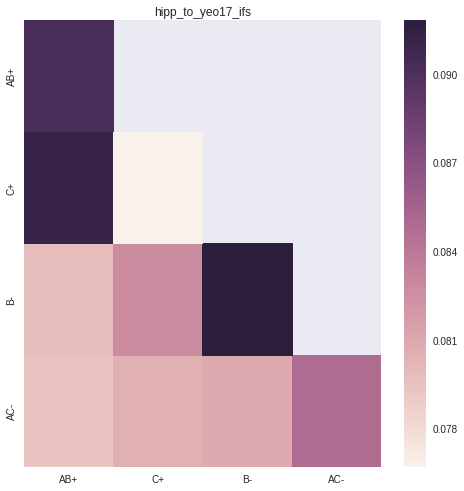

In [647]:
make_fig([x_roi,y_roi],all_cnf)

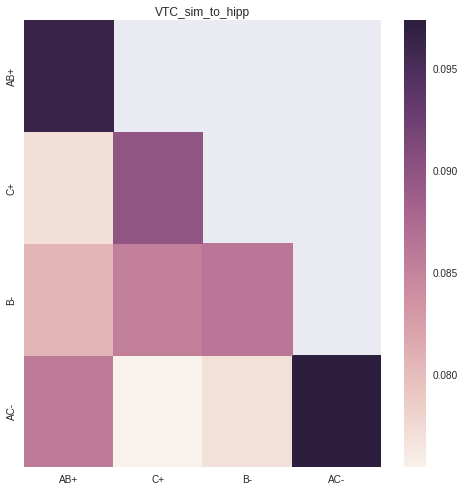

In [652]:
make_fig([x_roi,y_roi],all_cnf)

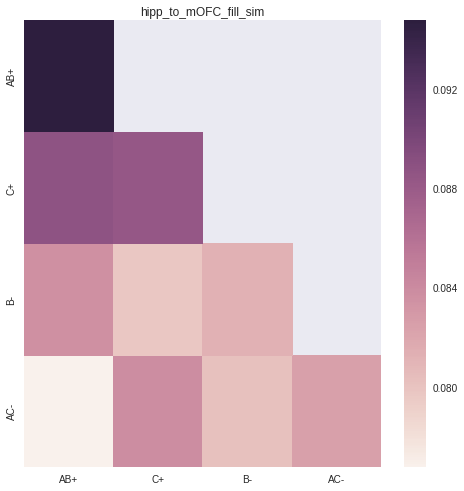

In [664]:
make_fig([x_roi,y_roi],all_cnf)